In [190]:
import numpy as np
import cv2
from sklearn import datasets
import matplotlib.pyplot as plt
import time
import math
%matplotlib inline

In [191]:
def detect_lines(img):
    # detekcija koordinata linije koristeci Hough transformaciju
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_img, "gray")
    plt.show()
    frame_thresh = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
#     ret, frame_thresh = cv2.threshold(gray_img, 120, 255, cv2.THRESH_BINARY)
    plt.imshow(frame_thresh, "gray")
    plt.show()
    edges_img = cv2.Canny(frame_thresh, 50, 100, apertureSize=3)
    plt.figure()    
    plt.imshow(edges_img, "gray")
    
    # minimalna duzina linije
    min_line_length = 300
    
    # Hough transformacija
    lines = cv2.HoughLinesP(image=edges_img, rho=1, theta=np.pi/180, threshold=50, lines=np.array([]),
                            minLineLength=min_line_length, maxLineGap=20)
    
#     print("Detektovane linije [[x1 y1 x2 y2]]: \n", lines)
    for i in range(len(lines)):
        cv2.line(edges_img, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255,0,0), 5);
              
    plt.figure()
    plt.imshow(edges_img, "gray")
    plt.show()
    time.sleep(10)
    
    return lines

In [192]:
def detect_rectangle(lines):
# detekcija pravougaonika od datih linija
    class Duz:
        def __init__(self, x1, y1, x2, y2):
            self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
            self.k = (float(y2) - float(y1)) / (float(x2) - float(x1))
            self.n = self.k * (float(-x1)) + float(y1)
        def __eq__(self, other):
            if self.x1 == other.x1 and self.y1 == other.y1 and self.x2 == other.x2 and self.y2 == other.y2:
                return True
            return False
        def pripada(self, tacka):
            if (tacka[0] > self.x1 and tacka[0] < self.x2) or (tacka[0] < self.x1 and tacka[0] > self.x2):
                if (tacka[1] > self.y1 and tacka[1] < self.y2) or (tacka[1] < self.y1 and tacka[1] > self.y2):
                    return True
            return False
        def __str__(self):
            return "Duz[(x1:"+str(self.x1)+",y1:"+str(self.y1)+"),(x2:"+str(self.x2)+",y2:"+str(self.y2)+"), k:" + str(self.k) + ",n:" + str(self.n) + "]" 
    class Presek:
        def __init__(self, duz1, duz2, tacka):
            self.duz1 = duz1
            self.duz2 = duz2
            self.tacka = tacka
            self.razdaljina = self.izracunaj_razdaljinu()
        def izracunaj_razdaljinu(self):
            if self.duz1.pripada(self.tacka):
                # Druga duz se morala produziti
                razdaljina1 = (self.duz2.x1 - self.tacka[0])**2 + (self.duz2.y1 - self.tacka[1])**2
                razdaljina2 = (self.duz2.x2 - self.tacka[0])**2 + (self.duz2.y2 - self.tacka[1])**2
            else:
                # Prva duz se morala produziti
                razdaljina1 = (self.duz1.x1 - self.tacka[0])**2 + (self.duz1.y1 - self.tacka[1])**2
                razdaljina2 = (self.duz1.x2 - self.tacka[0])**2 + (self.duz1.y2 - self.tacka[1])**2
            if razdaljina1 < razdaljina2:
                return razdaljina1
            else:
                return razdaljina2
        def __str__(self):
            return "Presek[Duz1:[" + str(self.duz1) + "] Duz2:[" + str(self.duz2) + "] Presek:" + str(self.tacka) + "] Razdaljina: [" + str(self.razdaljina) + "]"
            
    # formiraj duzi
    duzi = []
    for i in range(len(lines)):
        d = Duz(lines[i][0][0], lines[i][0][1], lines[i][0][2], lines[i][0][3])
        flag = False
        for duz in duzi:
            if abs(duz.k - d.k) < 0.1:
                flag = True
                break
        if not flag:
            duzi.append(d)
    # za svake dve duzi skapiraj najblizi presek
    preseci_total = []
    for i in range(len(duzi)-1):
        preseci = []
        for j in range(i+1, len(duzi)):
            # izracunaj presek
            x = -1 * (duzi[j].n - duzi[i].n) / (duzi[j].k - duzi[i].k)
            y = duzi[i].k * x + duzi[i].n
            p = Presek(duzi[i], duzi[j], (x, y))
#             print("Izracunat presek: " + str(p))
            # ako je presek unutar njih, to sacuvaj 
            if duzi[i].pripada((x, y)) or duzi[j].pripada((x,y)):
                preseci.append(p)
#                 print("Presek pripada duzi")
                break
            # presek unutar ekrana
            if x < 640.0 and x >= 0.0 and y >=0.0 and y < 480.0:
                preseci.append(p)
        preseci_total += preseci
#     print("\nOdabrani preseci:")
    preseci_tacke = []
    for p in preseci_total:
#         print(p)
        preseci_tacke.append(p.tacka)
    # ako je 2 preseka ostala dva su udaljenije tacke na pravama
    if len(preseci_total) == 2:
        presek1 = preseci_total[0]
        presek2 = preseci_total[1]
        zajednicka_duz = None
        if presek1.duz1 == presek2.duz1:
            zajednicka_duz = presek1.duz1
        elif presek1.duz1 == presek2.duz2:
            zajednicka_duz = presek1.duz1
        else:
            zajednicka_duz = presek1.duz2
        if presek1.duz1 != zajednicka_duz:
            razdaljina1 = (presek1.duz1.x1 - presek1.tacka[0])**2 + (presek1.duz1.y1 - presek1.tacka[1])**2
            razdaljina2 = (presek1.duz1.x2 - presek1.tacka[0])**2 + (presek1.duz1.y2 - presek1.tacka[1])**2
            if razdaljina1 > razdaljina2:
                preseci_tacke.append((presek1.duz1.x1, presek1.duz1.y1))
            else:
                preseci_tacke.append((presek1.duz1.x2, presek1.duz1.y2))
        else:
            razdaljina1 = (presek1.duz2.x1 - presek1.tacka[0])**2 + (presek1.duz2.y1 - presek1.tacka[1])**2
            razdaljina2 = (presek1.duz2.x2 - presek1.tacka[0])**2 + (presek1.duz2.y2 - presek1.tacka[1])**2
            if razdaljina1 > razdaljina2:
                preseci_tacke.append((presek1.duz2.x1, presek1.duz2.y1))
            else:
                preseci_tacke.append((presek1.duz2.x2, presek1.duz2.y2))
        if presek2.duz1 != zajednicka_duz:
            razdaljina1 = (presek2.duz1.x1 - presek2.tacka[0])**2 + (presek2.duz1.y1 - presek2.tacka[1])**2
            razdaljina2 = (presek2.duz1.x2 - presek2.tacka[0])**2 + (presek2.duz1.y2 - presek2.tacka[1])**2
            if razdaljina1 > razdaljina2:
                preseci_tacke.append((presek2.duz1.x1, presek2.duz1.y1))
            else:
                preseci_tacke.append((presek2.duz1.x2, presek2.duz1.y2))
        else:
            razdaljina1 = (presek2.duz2.x1 - presek2.tacka[0])**2 + (presek2.duz2.y1 - presek2.tacka[1])**2
            razdaljina2 = (presek2.duz2.x2 - presek2.tacka[0])**2 + (presek2.duz2.y2 - presek2.tacka[1])**2
            if razdaljina1 > razdaljina2:
                preseci_tacke.append((presek2.duz2.x1, presek2.duz2.y1))
            else:
                preseci_tacke.append((presek2.duz2.x2, presek2.duz2.y2))
            
    elif len(preseci_total) != 4:
        raise Exception("Granicne linije pravougaonika nisu pronadjene")
    return preseci_tacke
                    
    # Prikazi linije i preseke na mapi
    # na osnovu preseka pronadji najveci pravougaonik

In [193]:
# def count_people(frame):
#     frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# #     1. Naci masku - samo najtamnije izdvoj
#     _, mask = cv2.threshold(frame_gray, thresh=100, maxval=255, type=cv2.THRESH_BINARY)
# #     2. Prosiri bele piksele na njoj da se popune rupe crnih piksela
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     mask = cv2.dilate(mask, kernel, iterations=1)
#     mask = cv2.erode(mask, kernel, iterations=1)

#     mask = cv2.bitwise_not(mask)
#     plt.imshow(mask, "gray")
#     plt.show()
# #     3. Primeni masku
#     frame_gray = cv2.bitwise_and(frame_gray, mask)
#     plt.imshow(frame_gray, "gray")
#     plt.show()
#     frame_gray = cv2.bitwise_not(frame_gray)
# #     ret, frame_bin = cv2.threshold(frame_gray, 100, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # ret je izracunata vrednost praga, image_bin je binarna slika
# #     plt.imshow(frame_gray, "gray")
# #     plt.show()
#     # 4. Primeni treshold za izdvajanje ljudi
# #     ret, frame_bin = cv2.threshold(frame_gray, 100, 255, cv2.THRESH_BINARY)
# #     frame_bin = cv2.adaptiveThreshold(frame_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 10)
#     # 5. Primeni blur i druge transf
# #     plt.imshow(frame_bin, "gray")
# #     plt.show()
# #     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# #     frame_bin = cv2.dilate(frame_bin, kernel, iterations=1)
# #     frame_bin = cv2.erode(frame_bin, kernel, iterations=1)
# #     plt.imshow(frame_bin, "gray")
# #     plt.show()
# #     frame_bin = cv2.GaussianBlur(frame_bin,(5, 5),0)
# #     plt.imshow(frame_bin, "gray")
# #     plt.show()

#     frame_bin = cv2.Canny(frame_gray, 0, 100)
#     plt.imshow(frame_bin, "gray")
#     plt.show()

#     # 6. Nadji konture
#     contours, hierarchy = cv2.findContours(frame_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
#     contours_people = [] #ovde ce biti samo konture koje pripadaju bar-kodu
#     for contour in contours: # za svaku konturu
#         center, size, angle = cv2.minAreaRect(contour) # pronadji pravougaonik minimalne povrsine koji ce obuhvatiti celu konturu
#         width, height = size
#         if width > 15 and width < 150 and height > 10 and height < 100: # uslov da kontura pripada bar-kodu
#             contours_people.append(contour) # ova kontura pripada bar-kod
    
#     img = frame.copy()
#     cv2.drawContours(img, contours_people, -1, (255, 0, 0), 10)
#     if len(contours_people) > 0:
#         plt.imshow(frame_bin, "gray")
#         plt.show()
#         plt.imshow(img)
#         plt.show()
#     return len(contours_people)
    

In [194]:
def preprocess_image(image):
#     bilateral_filtered_image = cv2.bilateralFilter(image, 7, 150, 150)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

def count_people2(prev_frame, curr_frame):
    p1, p2 = preprocess_image(prev_frame), preprocess_image(curr_frame)
#     plt.imshow(p1, "gray")
#     plt.show()
#     plt.imshow(p2, "gray")
#     plt.show()
    image_sub = cv2.absdiff(p1, p2)
    image_sub = cv2.GaussianBlur(image_sub, (5,5), 0)

    close_operated_image = image_sub
#     close_operated_image = cv2.morphologyEx(image_sub, cv2.MORPH_CLOSE, kernel)
#     _, thresholded = cv2.threshold(close_operated_image, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     _, thresholded = cv2.threshold(close_operated_image, 20, 255, cv2.THRESH_BINARY)
    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
    thresholded_temp = cv2.adaptiveThreshold(image_sub, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 10)
    thresholded = cv2.dilate(thresholded_temp, k, iterations=2)
    
    contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.drawContours(thresholded, contours, -1, (255, 0, 0),10)
#     contours_people = [] #ovde ce biti samo konture koje pripadaju bar-kodu
#     for contour in contours: # za svaku konturu
#         center, size, angle = cv2.minAreaRect(contour) # pronadji pravougaonik minimalne povrsine koji ce obuhvatiti celu konturu
#         width, height = size
#         if width > 5 and width < 150 and height > 5 and height < 100: # uslov da kontura pripada bar-kodu
#             contours_people.append(contour) # ova kontura pripada bar-kod
#     if len(contours) > 0:
# #         plt.imshow(p1, "gray")
# #         plt.show()
# #         plt.imshow(p2, "gray")
# #         plt.show()
#         print("Razlika i blur")
#         plt.imshow(image_sub, "gray")
#         plt.show()
# #         print("Morfolosko zatvaranje")
# #         plt.imshow(close_operated_image, "gray")
# #         plt.show()
#         print("Treshold")
#         plt.imshow(thresholded_temp, "gray")
#         plt.show()
#         print("Dilated")
#         plt.imshow(thresholded, "gray")
#         plt.show()
#         print("Konture")
#         thresholded = cv2.drawContours(thresholded, contours, -1, (255, 0, 0),8)
#         plt.imshow(thresholded)
#         plt.show()
#         print("Broj kontura: " + str(len(contours)))
    return len(contours)

In [195]:
# frame_num = 0
# cap = cv2.VideoCapture("data/video2.mp4")
# cap.set(1, frame_num) # indeksiranje frejmova

# # analiza videa frejm po frejm
# diff = 0
# prev = [0, 0, 0, 0]
# prev_frame = None
# while True:
#     frame_num += 1
#     ret_val, frame = cap.read()

#     # ako frejm nije zahvacen
#     if not ret_val:
#         break

#     curr = 0    
      
#     if frame_num == 1:
#         prev_frame = frame
#         continue
        
# #     if frame_num % 2 != 0:
# #         continue
                
#     min_x, max_x, min_y, max_y = 151, 515, 93, 429    
        
# #     if frame_num == 1: # ako je prvi frejm, detektuj liniju
# #         lines = detect_lines(frame)
# #         preseci = detect_rectangle(lines)
# #         for p in preseci:
# #             frame = cv2.circle(frame, (int(p[0]),int(p[1])), radius=20, color=(0, 0, 255), thickness=-1)
# #         plt.imshow(frame)
# #         frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# #         min_x = int(min([tacka[0] for tacka in preseci]))
# #         max_x = int(max([tacka[0] for tacka in preseci]))
# #         min_y = int(min([tacka[1] for tacka in preseci]))
# #         max_y = int(max([tacka[1] for tacka in preseci]))
# #         print(min_x, max_x, min_y, max_y)
# #         plt.show()
        
#     cropped_image1 = frame[min_y:max_y, min_x:max_x]
#     cropped_image2 = prev_frame[min_y:max_y, min_x:max_x]
# #     plt.imshow(cropped_image)
# #     plt.show()
#     curr = count_people2(cropped_image1, cropped_image2)
#     prev = prev[1:4]
#     prev.append(curr)
#     flag = True if prev[1] == prev[2] == prev[3] else False
#     if curr > prev[0] and flag:
#         diff += curr - prev[0]
#         print("brojac: " + str(diff) + " trenutno: " + str(curr))
#         plt.imshow(frame)
#         plt.show()
#     elif flag and diff == 0 and curr != 0:
#         diff = curr
#         print("brojac: " + str(diff) + " trenutno: " + str(curr))
#         plt.imshow(frame)
#         plt.show()
#     prev_frame = frame
# #     print(prev)
# print(diff)
    

In [196]:
def analyze_video(path):
    frame_num = 0
    cap = cv2.VideoCapture(path)
    cap.set(1, frame_num) # indeksiranje frejmova

    # analiza videa frejm po frejm
    diff = 0
    prev = [0, 0, 0, 0]
    prev_frame = None
    while True:
        frame_num += 1
        ret_val, frame = cap.read()

        # ako frejm nije zahvacen
        if not ret_val:
            break

        curr = 0    

        if frame_num == 1:
            prev_frame = frame
            
            if analyze_video.min_x == None:
                print("Pronalazak platoa u toku...")
                lines = detect_lines(frame)
                preseci = detect_rectangle(lines)
                f2 = frame.copy()
                for p in preseci:
                    f2 = cv2.circle(f2, (int(p[0]),int(p[1])), radius=20, color=(0, 0, 255), thickness=-1)
                plt.imshow(f2)
                plt.show()
                analyze_video.min_x = int(min([tacka[0] for tacka in preseci]))
                analyze_video.max_x = int(max([tacka[0] for tacka in preseci]))
                analyze_video.min_y = int(min([tacka[1] for tacka in preseci]))
                analyze_video.max_y = int(max([tacka[1] for tacka in preseci]))
                print("Pronalazak platoa zavrsen. Nastavak obrade video-klipa.")
            continue

#         min_x, max_x, min_y, max_y = 151, 515, 93, 429    

        

        cropped_image1 = frame[min_y:max_y, min_x:max_x]
        cropped_image2 = prev_frame[min_y:max_y, min_x:max_x]
    #     plt.imshow(cropped_image)
    #     plt.show()
        curr = count_people2(cropped_image1, cropped_image2)
        prev = prev[1:4]
        prev.append(curr)
        flag = True if prev[1] == prev[2] == prev[3] else False
        if curr > prev[0] and flag:
            diff += curr - prev[0]
#             print("brojac: " + str(diff) + " trenutno: " + str(curr))
#             plt.imshow(frame)
#             plt.show()
        elif flag and diff == 0 and curr != 0:
            diff = curr
#             print("brojac: " + str(diff) + " trenutno: " + str(curr))
#             plt.imshow(frame)
#             plt.show()
        prev_frame = frame
    #     print(prev)
    return diff

analyze_video.min_x = None
analyze_video.max_x = None
analyze_video.min_y = None
analyze_video.max_y = None

analyzing video: data/video1.mp4
Pronalazak platoa u toku...


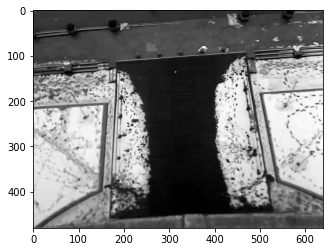

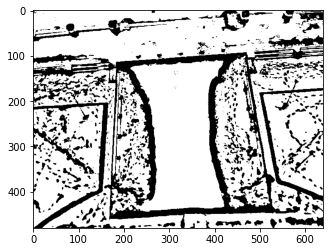

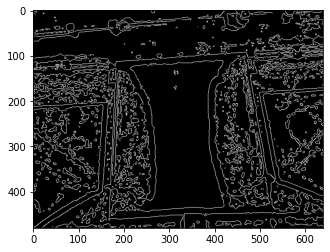

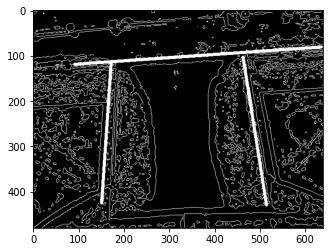

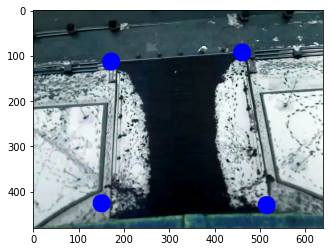

Pronalazak platoa zavrsen. Nastavak obrade video-klipa.
resenje: 6
analyzing video: data/video2.mp4
resenje: 18
analyzing video: data/video3.mp4
resenje: 20
analyzing video: data/video4.mp4
resenje: 20
analyzing video: data/video5.mp4
resenje: 19
analyzing video: data/video6.mp4
resenje: 26
analyzing video: data/video7.mp4
resenje: 29
analyzing video: data/video8.mp4
resenje: 10
analyzing video: data/video9.mp4
resenje: 8
analyzing video: data/video10.mp4
resenje: 9

Konacno resenje: 4.5


In [197]:
BROJ_KLIPOVA = 10
razlika = 0
tacno = {
    "video1.mp4": 4,
    "video2.mp4":24,
    "video3.mp4":17,
    "video4.mp4":23,
    "video5.mp4":17,
    "video6.mp4":27,
    "video7.mp4":29,
    "video8.mp4":22,
    "video9.mp4":10,
    "video10.mp4":23
}

for i in range(1, BROJ_KLIPOVA + 1):
    path = "video" + str(i) + ".mp4"
    full_path = "data/" + path
    print("analyzing video: " + full_path)
    try:
        f = open(full_path)
    except IOError:
        print("Fajl ne postoji. Da li ste preuzeli klipove i stavili ih u data/ direktorijum?")
    finally:
        f.close()
    resenje = analyze_video(full_path)
    razlika += abs(tacno[path] - resenje)
    print("resenje: " + str(resenje))
print("\nKonacno resenje: " + str(razlika / BROJ_KLIPOVA))